In [38]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [39]:
transforms = transforms.ToTensor() #definindo a conversão de imagem para tensor
trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) #carrega parte do treino do dataset

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) #Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transforms) #Carrega a parte de validação
#valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transforms.ToTensor()) 
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False) #Cria um buffer para pegar os dados 


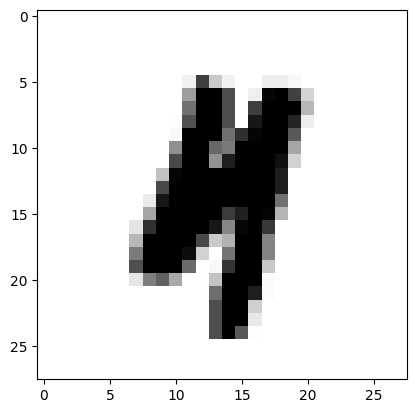

In [40]:
#testando leitura da base de dados para conferir se estamos conseguindo ler a base de dados de forma correta
dataiter = iter(trainloader)
#imagens, etiquetas = dataiter.next()
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [41]:
#conferindo o tamanho do tensor que representa a imagem
print(imagens[0].shape) # verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) #verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [42]:
#Montando extrutura da rede
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) #camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) #camada interna 1, 128 neuronios que se ligam a 64
        self.Linear3 = nn.Linear(64, 10) #camada interna 2, 64 neurônios que se ligam a 10
        #para a camada de saída não é necessário definir nada pois só precisamo pestar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) #função de ativação de cada camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) #função de ativação de cada camada de entrada para a camada interna 2
        X = self.Linear3(X) #função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) #dados utilizados para calcular a perda
    

In [43]:
#Extrutura de treinamento
def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) #definie a política de atualização dos pesos e da bias
    inicio = time() #timer para sabermos quanto tempo levou o treinamento

    criterio = nn.MLLoss() #definie o critério para calcular a perda
    EPOCHS= 10 #número de épocas que o algoritmo rodará
    modelo.train() #ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 #inicializaçõa da perda acumulada da época época

        for imagens, etiquetas in trainloader:

            imagens, imagens.view(imagens.shape[0], -1) #convertendo imagens para "vetores" de 28*28 casas
            otimizador.zero_grad() #zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) #colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(devide)) #calculando a perda da época em questão
            
            perda_instantanea.backward() #back propagation a partir da perda

            otimizador.step() #atualizando os pesos e a baias

            perda_acumulada +- perda_instantanea.item() #atualizando perda acumulada

        else:
            print("Epoch {} - Perda resultante: {}". format(epoch+1, perda_acumulada/len(trainloader)))
    print("\nTempo de treino (em minutos) = ", (time()-inicio)/60)


In [44]:
#Modelo de Validação da base de dados de treino com o que está acontecendo no treinamento
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1,784)
            #desativar o autograd para celerar a validação. Grafos conputacionais dinâmicos tem um custo alto de processamento
            with torch.no_grad():
                logps = modelo(img.to(devide)) #output do modelo em escala logaritmica

            ps = torch.exp(logps) #converte output para escala normal (lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0])
            etiqueta_pred = probab.index(max(probab)) #converte o tensor em um número, no caso, o núemro que o modelo previu
            etiqueta_certa = etiquetas.numpy()[i]
            if(etiqueta_certa == etiqueta_pred): #compra a previsão com o valor correto
                conta_corretas == 1
            conta_todas == 1

        print("Total de imagens testadas = ", conta_todas)
        print("\nPrecisão do modelo = {}%".format(conta_corretas*10/conta_todas))


In [45]:
#Leitura do modelo que irá rodar efetivamente na rede
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)


Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (Linear3): Linear(in_features=64, out_features=10, bias=True)
)